In [1]:
# Load the Python libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# Load Surprise libraries
from surprise import SVD
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

In [3]:
# Load plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# interactions_df = pd.read_excel(r'C:\Users\Kye Manning-Lees\Canva\sampleData.xlsx', sheet_name='interactions')
# user_df = pd.read_excel(r'C:\Users\Kye Manning-Lees\Canva\sampleData.xlsx', sheet_name='UserMetadata')
# template_df = pd.read_excel(r'C:\Users\Kye Manning-Lees\Canva\sampleData.xlsx', sheet_name='TempMetadata')
# template_df

movies_df = pd.read_csv('movies.csv')
ratings_df = pd.read_csv('ratings.csv')
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [5]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [6]:
df = pd.merge(movies_df, ratings_df, on='movieId')
df = df.drop(columns=['genres', 'timestamp'])
df

,movieId,title,userId,rating
0,1,Toy Story (1995),1,4.0
1,1,Toy Story (1995),5,4.0
2,1,Toy Story (1995),7,4.5
3,1,Toy Story (1995),15,2.5
4,1,Toy Story (1995),17,4.5
...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),184,4.0
100832,193583,No Game No Life: Zero (2017),184,3.5
100833,193585,Flint (2017),184,3.5
100834,193587,Bungo Stray Dogs: Dead Apple (2018),184,3.5


In [7]:
ratings = pd.DataFrame(df.groupby('movieId')['rating'].mean())
ratings['count'] = pd.DataFrame(df.groupby('movieId')['rating'].count())
ratings.sort_values('count', ascending = False).head(10) # here we can reduce the quantity by only keeping count>10

,rating,count
movieId,,
356,4.164134,329
318,4.429022,317
296,4.197068,307
593,4.161290,279
2571,4.192446,278
260,4.231076,251
480,3.750000,238
110,4.031646,237
589,3.970982,224


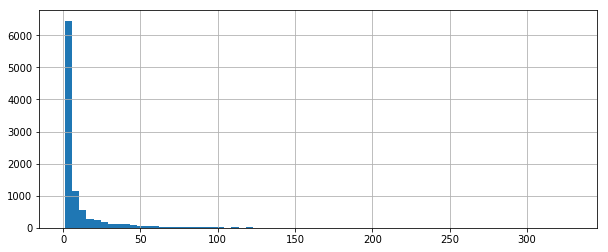

In [8]:
plt.figure(figsize = (10, 4))
ratings['count'].hist(bins = 70)
plt.show()

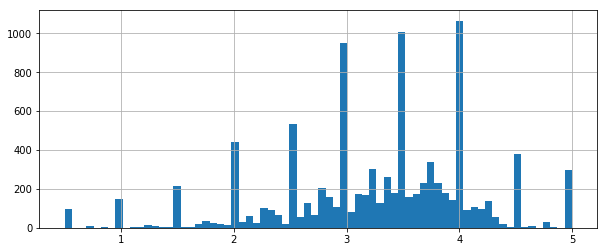

In [9]:
plt.figure(figsize = (10, 4))
ratings['rating'].hist(bins = 70)
plt.show()

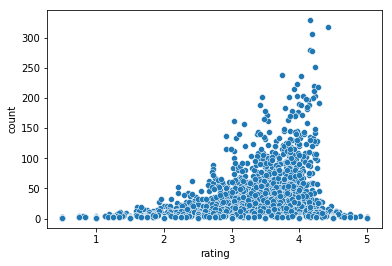

In [10]:
sns.scatterplot(data=ratings, x='rating', y='count')

In [11]:
ratings.sort_values(by='count',ascending=False)

,rating,count
movieId,,
356,4.164134,329
318,4.429022,317
296,4.197068,307
593,4.161290,279
2571,4.192446,278
...,...,...
4093,1.500000,1
4089,2.000000,1
58351,4.000000,1


# Split Data

In [12]:
train_data, test_data = train_test_split(ratings_df, test_size = 0.2)
print("Train size:", train_data.shape)    # 80.00%
print("Test size:", test_data.shape)      # 20.00%

Train size: (80668, 4)
Test size: (20168, 4)


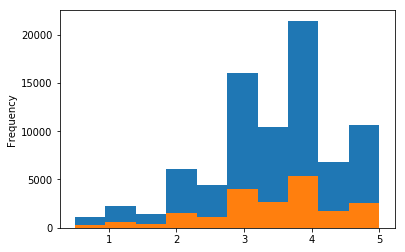

In [13]:
train_data.rating.plot.hist(bins = 10)
test_data.rating.plot.hist(bins = 10)
plt.show()

# Read Data

In [14]:
train_data

,userId,movieId,rating,timestamp
73914,474,2890,3.5,1053021616
43482,291,91542,4.0,1453051506
55523,368,1193,5.0,971273035
16822,105,112552,4.0,1446571942
81054,513,235,4.5,1159980374
...,...,...,...,...
22693,156,47,3.5,1106854709
83892,534,69122,4.0,1459787998
42572,288,2402,1.0,978466832
38290,263,1196,4.0,941591604


In [15]:
reader = Reader(rating_scale = (1, 5))
data_train = Dataset.load_from_df(train_data[['userId', 'movieId', 'rating']], reader)
data_test = Dataset.load_from_df(test_data[['userId', 'movieId', 'rating']], reader)

In [16]:
# Build full trainset
data_train = data_train.build_full_trainset()
data_test = data_test.build_full_trainset()

In [17]:
mean = data_train.global_mean
print('Train rating', mean)

Train rating 3.5016115436108493


In [18]:
mean = data_test.global_mean
print('Test rating', mean)

Test rating 3.5013387544625147


In [19]:
# Create the trainset and testset
data_trainset = data_train.build_testset()
data_testset = data_test.build_testset()

# Train Model

In [20]:
algo = SVD()
algo.fit(data_train)
# cross_validate(algo, data_trainset, measures=['RMSE', 'MAE'], cv=5, verbose=False)

In [21]:
predictions = algo.test(data_testset)
accuracy.rmse(predictions)

RMSE: 0.8710


0.8709637077775649

In [22]:
algo.predict(uid='196', iid='196')

Prediction(uid='196', iid='196', r_ui=None, est=3.5016115436108493, details={'was_impossible': False})

In [23]:
# Create SVD algorithm with 5 factors
k_factors = 5
algo = SVD(n_factors= k_factors, n_epochs= 200, biased= True, lr_all= 0.005, reg_all= 0, init_mean= 0, init_std_dev= 0.01)

# Train the algorithm on the trainset
algo.fit(data_train)

In [30]:
predictions = algo.test(data_testset)
predictions[:10]

[Prediction(uid=525, iid=159817, r_ui=4.5, est=4.192222383757808, details={'was_impossible': False}),
 Prediction(uid=525, iid=2006, r_ui=3.5, est=2.4583698967870573, details={'was_impossible': False}),
 Prediction(uid=525, iid=42734, r_ui=4.0, est=2.817839772602338, details={'was_impossible': False}),
 Prediction(uid=525, iid=58998, r_ui=4.0, est=3.3761510139486766, details={'was_impossible': False}),
 Prediction(uid=525, iid=96610, r_ui=4.0, est=3.836364189207206, details={'was_impossible': False}),
 Prediction(uid=525, iid=40815, r_ui=3.0, est=3.826612760769729, details={'was_impossible': False}),
 Prediction(uid=525, iid=88405, r_ui=2.5, est=3.5584196164364523, details={'was_impossible': False}),
 Prediction(uid=525, iid=61024, r_ui=2.0, est=3.3368243825405046, details={'was_impossible': False}),
 Prediction(uid=525, iid=2018, r_ui=1.5, est=3.477010026239147, details={'was_impossible': False}),
 Prediction(uid=525, iid=7361, r_ui=3.5, est=4.1781358855619075, details={'was_impossibl

In [25]:
# Calculate RMSE for training dataset
train_pred = algo.test(data_trainset)
accuracy.rmse(train_pred)

RMSE: 0.5778


0.577766730087649

In [26]:
accuracy.mae(train_pred)

MAE:  0.4209


0.42085414816810357

In [27]:
# Calculate RMSE for test dataset
test_pred = algo.test(data_testset)
accuracy.rmse(test_pred)

RMSE: 0.9503


0.9503408219078732

# Auto Tune

In [28]:
train_data.columns = ['userId', 'movieId', 'raw_ratings', 'ts']
train_data = train_data.drop(columns=['ts'])
train_data

,userId,movieId,raw_ratings
73914,474,2890,3.5
43482,291,91542,4.0
55523,368,1193,5.0
16822,105,112552,4.0
81054,513,235,4.5
...,...,...,...
22693,156,47,3.5
83892,534,69122,4.0
42572,288,2402,1.0
38290,263,1196,4.0


In [29]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(train_data[['userId', 'movieId', 'raw_ratings']], reader)

cross_validate(NormalPredictor(), data, cv=2)

NameError: name 'NormalPredictor' is not defined

In [31]:
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8713  0.8879  0.8822  0.8845  0.8816  0.8815  0.0056  
MAE (testset)     0.6731  0.6827  0.6794  0.6812  0.6784  0.6790  0.0033  
Fit time          2.88    2.95    2.92    2.94    2.92    2.92    0.02    
Test time         0.13    0.08    0.07    0.08    0.07    0.09    0.02    


{'test_rmse': array([0.87133075, 0.88794496, 0.88221997, 0.88451601, 0.88158927]),
 'test_mae': array([0.67311532, 0.68272802, 0.67943249, 0.68118083, 0.67835784]),
 'fit_time': (2.8843913078308105,
  2.9467029571533203,
  2.922783136367798,
  2.9377105236053467,
  2.9228312969207764),
 'test_time': (0.13068008422851562,
  0.07978653907775879,
  0.0698084831237793,
  0.07881808280944824,
  0.06981348991394043)}

In [32]:
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005], 'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['RMSE', 'MAE'], cv=3)
gs.fit(data)

In [33]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8994155017020079
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


# manual

In [34]:
df = ratings_df.drop(columns=['timestamp'])

In [35]:
train_data, test_data = train_test_split(df, test_size = 0.2)
print("Train size:", train_data.shape)    # 80.00%
print("Test size:", test_data.shape)      # 20.00%

reader = Reader(rating_scale = (1, 5))
data_train = Dataset.load_from_df(train_data[['userId', 'movieId', 'rating']], reader)
data_test = Dataset.load_from_df(test_data[['userId', 'movieId', 'rating']], reader)

data_train = data_train.build_full_trainset()
data_test = data_test.build_full_trainset()

Train size: (80668, 3)
Test size: (20168, 3)


In [36]:
data_test

In [37]:
algo = SVD()
algo.fit(data_train)

In [38]:
predictions = algo.test(data_test)

TypeError: 'Trainset' object is not iterable

In [39]:
accuracy.rmse(predictions)

RMSE: 0.9503


0.9503408219078732

In [40]:
# Top N

In [41]:
df

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [48]:
from collections import defaultdict
topN = defaultdict(list)
for userID, movieID, actualRating, estimatedRating, _ in test_pred:
    if estimatedRating >= 4:
        topN[int(userID)].append((int(movieID), estimatedRating))

print(topN[1])

[(1226, 4.5849897121898335), (2033, 4.152148041673595), (2161, 4.657492633954577), (2115, 4.569639760642657), (1278, 4.728251604011917), (1213, 4.913160384573886), (500, 4.058609703368168), (2406, 4.291790870018674), (2078, 4.7262225008344885), (2580, 4.880329877043795), (1573, 4.556885826504005), (3034, 4.102693230722225), (2949, 4.530987987640902), (2414, 4.1813960082779715), (1258, 4.414291780451582), (1500, 4.384502426109849), (2018, 4.286032225686671), (3578, 4.616826209280173), (648, 4.266558318067239), (2174, 4.382061857833473), (2502, 4.682083316684495), (2291, 4.5616059349947795), (3729, 4.139175931949281), (47, 4.641502117698983), (2571, 4.825969166421449), (780, 4.295978207234315), (1927, 4.554490782770597), (223, 4.463768210154217), (1517, 4.395927838652224), (1732, 4.490364347905735), (3053, 4.313636179680824), (733, 4.617767611732901), (2353, 4.179403542371911)]


In [50]:
for userID, ratings in topN.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        topN[int(userID)] = ratings[:10]
print(topN[1])

[(1213, 4.913160384573886), (2580, 4.880329877043795), (2571, 4.825969166421449), (1278, 4.728251604011917), (2078, 4.7262225008344885), (2502, 4.682083316684495), (2161, 4.657492633954577), (47, 4.641502117698983), (733, 4.617767611732901), (3578, 4.616826209280173)]


# Make Predictions

In [51]:
train_data.head(5)

,userId,movieId,rating
61668,408,74789,3.0
29578,202,1641,4.0
7047,47,140247,1.0
100035,610,7846,3.0
29751,202,3527,4.0


In [52]:
# Prediction without real rating
p1 = algo.predict(uid = train_data.iloc[0].userId, iid = train_data.iloc[0].movieId, verbose = True)

user: 408.0      item: 74789.0    r_ui = None   est = 3.43   {'was_impossible': False}


In [53]:
# Prediction with real rating
p2 = algo.predict(uid = 196, iid = 302, r_ui = 4, verbose = True)

user: 196        item: 302        r_ui = 4.00   est = 3.41   {'was_impossible': False}


# Model Tune

In [54]:
reader = Reader(rating_scale = (1, 5))
dataset = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

In [55]:
# SVD params: 3 * 3 * 3 * 3 combinations
param_grid = {'n_factors': [5, 10, 20],
              'n_epochs': [20, 30, 50],
              'lr_all': [0.002, 0.005, 0.01],
              'reg_all': [0.02, 0.05, 0.1]}

In [56]:
# Tune algorithm parameters with GridSearchCV and k=4 cross-validation 
gs = GridSearchCV(SVD, param_grid, measures = ['rmse', 'mae'], cv = 4)
gs.fit(dataset)

In [57]:
# Best RMSE and MAE scores
gs.best_score

{'rmse': 0.8593804454911871, 'mae': 0.6578286240013557}

In [58]:
# Combination of parameters that gave the best scores
gs.best_params

{'rmse': {'n_factors': 20, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1},
 'mae': {'n_factors': 20, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}}